In [8]:
# Загрузка датасета
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "arunjathari/bostonhousepricedata",
    "Boston-house-price-data.csv"
)

print("Первые 5 записей:")
df.head()

Using Colab cache for faster access to the 'bostonhousepricedata' dataset.
Первые 5 записей:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


# Добавление нового атрибута

In [9]:
# Создаем новый атрибут - "rooms_price_ratio"
# Это отношение средней стоимости домов в 1000 долларов к среднему количеству комнат в доме
df['rooms_price_ratio'] = df['MEDV'] / df['RM']

# Характеристики нового атрибута
print("Статистика по новому атрибуту:")
print(df['rooms_price_ratio'].describe())

Статистика по новому атрибуту:
count    506.000000
mean       3.526268
std        1.175943
min        0.879817
25%        2.859213
50%        3.471343
75%        4.035125
max       10.060362
Name: rooms_price_ratio, dtype: float64


# Обработка датасета

In [10]:
# Проверка на пропущенные значения
print("\nПропущенные значения по столбцам:")
print(df.isnull().sum())

# Удаление дубликатов
initial_count = len(df)
df = df.drop_duplicates()
print(f"\nУдалено дубликатов: {initial_count - len(df)}")

print(f"\nКоличество записей до удаления выбросов: {len(df)}")

# Одновременное удаление выбросов с IQR
def get_combined_outlier_mask(df, columns):
    mask = pd.Series([True] * len(df))
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        column_mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)
        mask &= column_mask
    return mask

# Исключаем бинарный атрибут CHAS, все остальные обрабатываем
numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'CHAS']

print(f"Обрабатываем выбросы в {len(numeric_columns)} столбцах")

# Применяем одновременное удаление
outlier_mask = get_combined_outlier_mask(df, numeric_columns)
df = df[outlier_mask].copy()

print(f"Количество записей после удаления выбросов: {len(df)}")


Пропущенные значения по столбцам:
CRIM                 0
ZN                   0
INDUS                0
CHAS                 0
NOX                  0
RM                   0
AGE                  0
DIS                  0
RAD                  0
TAX                  0
PTRATIO              0
B                    0
LSTAT                0
MEDV                 0
rooms_price_ratio    0
dtype: int64

Удалено дубликатов: 0

Количество записей до удаления выбросов: 506
Обрабатываем выбросы в 14 столбцах
Количество записей после удаления выбросов: 287


# Построение графиков зависимости одной переменной от другой

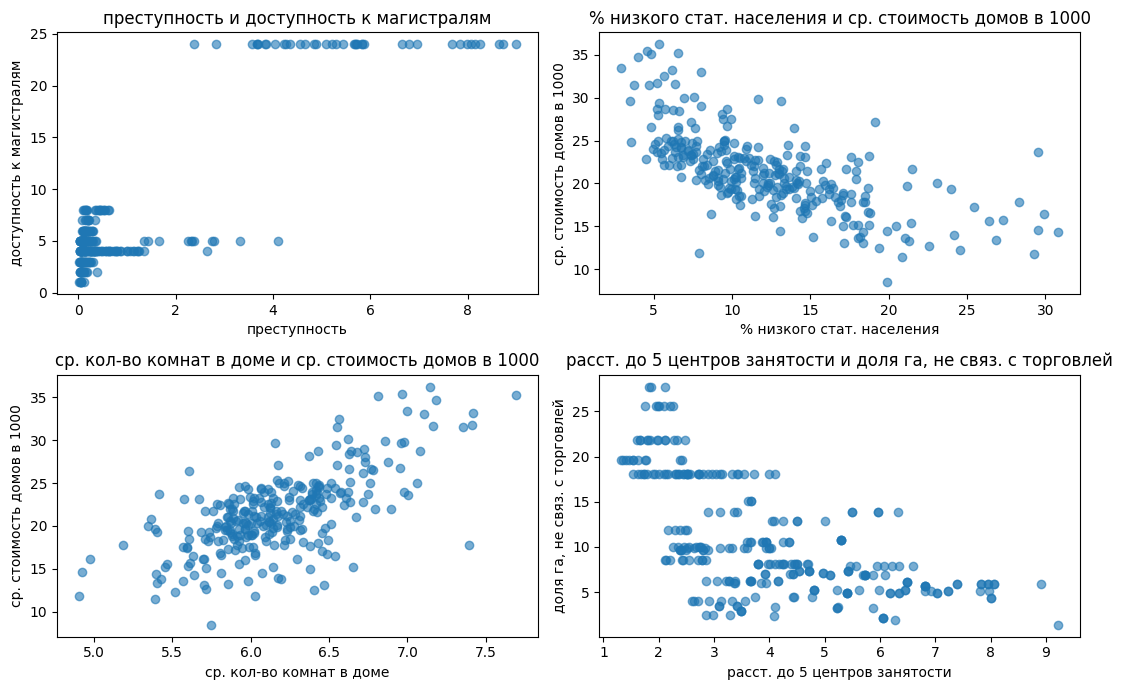

In [11]:
# Построение графиков зависимостей одних переменных от других для выявления кластеров
plt.figure(figsize=(11, 7))

# График 1: CRIM vs RAD
plt.subplot(2, 2, 1)
plt.scatter(df['CRIM'], df['RAD'], alpha=0.6)
plt.title('преступность и доступность к магистралям')
plt.xlabel('преступность')
plt.ylabel('доступность к магистралям')

# График 2: LSTAT vs MEDV
plt.subplot(2, 2, 2)
plt.scatter(df['LSTAT'], df['MEDV'], alpha=0.6)
plt.title('% низкого стат. населения и ср. стоимость домов в 1000')
plt.xlabel('% низкого стат. населения')
plt.ylabel('ср. стоимость домов в 1000')

# График 3: RM vs MEDV
plt.subplot(2, 2, 3)
plt.scatter(df['RM'], df['MEDV'], alpha=0.6)
plt.title('ср. кол-во комнат в доме и ср. стоимость домов в 1000')
plt.xlabel('ср. кол-во комнат в доме')
plt.ylabel('ср. стоимость домов в 1000')

# График 4: DIS vs INDUS
plt.subplot(2, 2, 4)
plt.scatter(df['DIS'], df['INDUS'], alpha=0.6)
plt.title('расст. до 5 центров занятости и доля га, не связ. с торговлей')
plt.xlabel('расст. до 5 центров занятости')
plt.ylabel('доля га, не связ. с торговлей')

plt.tight_layout()
plt.show()

# Описание кластеров

На первом графике "преступность и доступность к магистралям" видна положительная корреляция, чем больше доступность магистралей, тем больше преступность. Видны две группы точек: малая доступность магистралей при малой преступности и большая доступность магистралей при большой преступности. На графике "% низкого стат. населения и ср. стоимость домов в 1000" наблюдается отрицательная корреляция, чем больше % низкого статуса населения, тем меньше средняя стоимость домов. На 3 графике "ср. кол-во комнат в доме и ср. стоимость домов в 1000" положительная корреляция, чем больше комнат в доме, тем он дороже. На 2 и 3 графиках наблюдается по одному скоплению точек. И на последнем графике видна отрицательная корреляция, чем больше расстояние от центров занятости, тем меньше доля гектар, не связанных с розничной торговлей.

# Реализация метода K-means

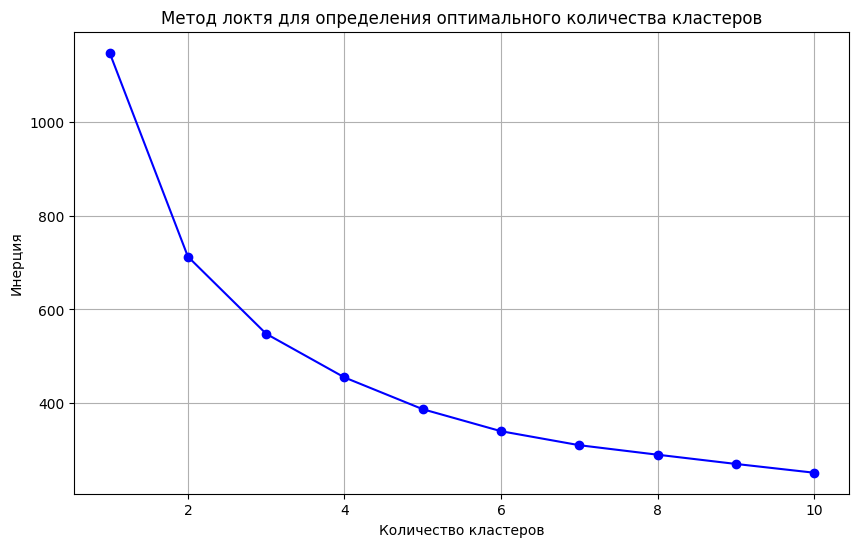

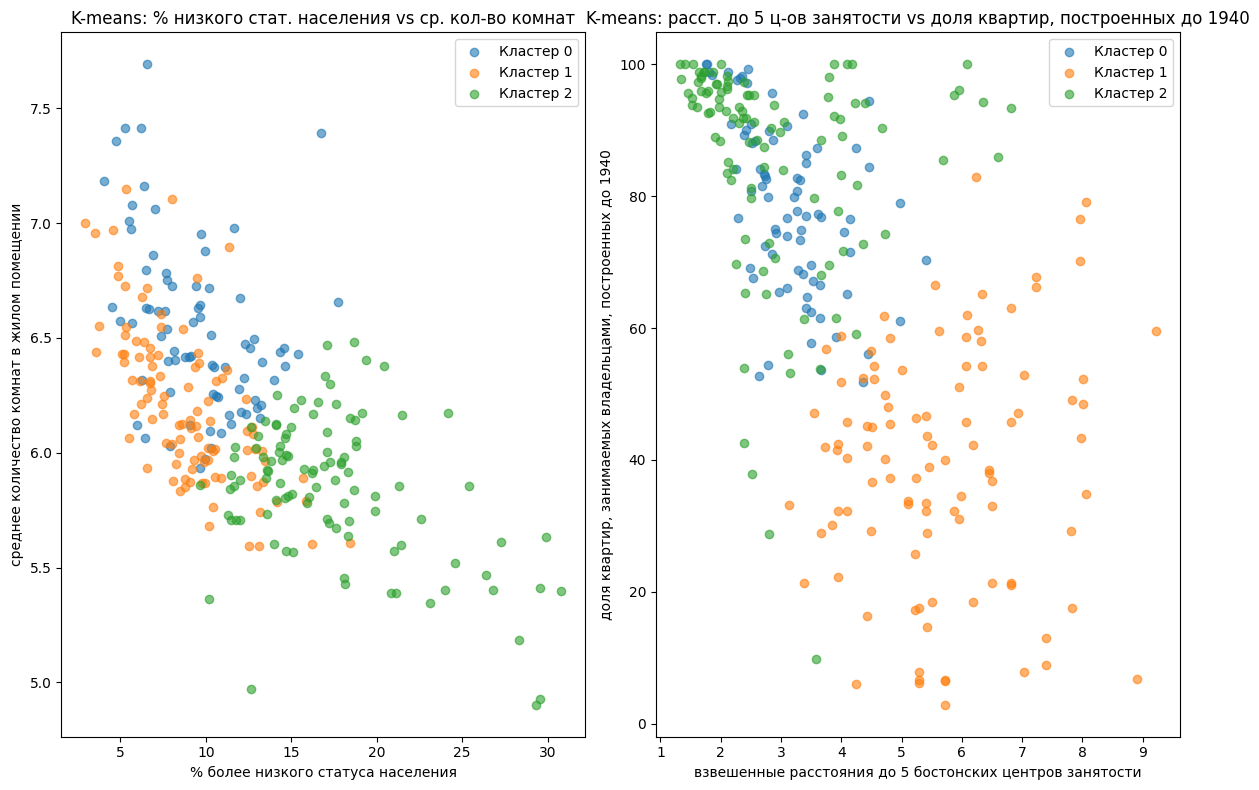


Средние значения признаков по кластерам:
             LSTAT        RM       DIS        AGE
cluster                                          
0         9.558228  6.541152  3.143867  78.645570
1         8.887184  6.208796  5.661536  39.525243
2        17.415143  5.848352  2.910057  85.357143

Среднее MEDV по кластерам:
   cluster       MEDV
0        0  23.559494
1        1  23.060194
2        2  18.246667


In [12]:
# Подготовка данных для метода K-Means
# Атрибуты для кластеризации
features = ['LSTAT', 'RM', 'DIS', 'AGE']
X = df[features].values

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Определяем оптимальное количество кластеров с помощью метода локтя
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertias, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.title('Метод локтя для определения оптимального количества кластеров')
plt.grid(True)
plt.show()

# Применение метода K-means с оптимальным количеством кластеров (из метода локтя выбираем 3)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Визуализация результатов кластеризации
plt.figure(figsize=(12, 8))

# LSTAT vs RM
plt.subplot(1, 2, 1)
for cluster in range(optimal_clusters):
    cluster_data = df[df['cluster'] == cluster]
    plt.scatter(cluster_data['LSTAT'], cluster_data['RM'],
                label=f'Кластер {cluster}', alpha=0.6)
plt.title('K-means: % низкого стат. населения vs ср. кол-во комнат')
plt.xlabel('% более низкого статуса населения')
plt.ylabel('среднее количество комнат в жилом помещении')
plt.legend()

# DIS vs AGE
plt.subplot(1, 2, 2)
for cluster in range(optimal_clusters):
    cluster_data = df[df['cluster'] == cluster]
    plt.scatter(cluster_data['DIS'], cluster_data['AGE'],
                label=f'Кластер {cluster}', alpha=0.6)
plt.title('K-means: расст. до 5 ц-ов занятости vs доля квартир, построенных до 1940')
plt.xlabel('взвешенные расстояния до 5 бостонских центров занятости')
plt.ylabel('доля квартир, занимаемых владельцами, построенных до 1940')
plt.legend()

plt.tight_layout()
plt.show()

# Анализ характеристик кластеров
print("\nСредние значения признаков по кластерам:")
cluster_analysis = df.groupby('cluster')[features].mean()
print(cluster_analysis)

# Вычисление среднего значения стоимости домов по кластерам
df['cluster'] = kmeans.labels_
medv_by_cluster = df.groupby('cluster')['MEDV'].mean().reset_index()

print("\nСреднее MEDV по кластерам:")
print(medv_by_cluster)

# Выводы по результатам кластеризации методом K-means
1. Определение оптимального числа кластеров

С помощью метода локтя было установлено, что оптимальное количество кластеров для данного набора данных — 3.

2. Характеристики кластеров

Кластер 0: Отличается повышенным % населения с низким статусом, немного пониженным количеством комнат, средним взвешенным расстоянием до центров занятости и высокой долей квартир, занимаемых владельцами, построенных до 1940 года.

Кластер 1: Характеризуется низкой долей населения с низким статусом, средним числом комнат, большим расстоянием до центров занятости и низкой долей квартир, занимаемых владельцами, построенных до 1940 года.

Кластер 2: Имеет низкий процент населения с низким статусом, немного повышенным количество комнат, средним расстоянием до центров занятости и средней долей квартир, занимаемых владельцами, построенных до 1940 года.

3. Взаимосвязь со стоимостью недвижимости

Из проведенного анализа видно связь между кластерной принадлежностью и средней стоимостью жилья: для кластера 0 характерна пониженная стоимость, для 1 кластера средняя, а кластер 2 демонстрирует более высокие ценовые показатели.

4. Полученная кластеризация позволяет:

- Сегментировать объекты недвижимости по ключевым параметрам: социальному статусу населения, количеству комнат, доступности 5 центров занятости и доле квартир, построенных до 1940 года.

- Использовать выделенные сегменты для разработки дифференцированных ценовых стратегий и анализа рынка недвижимости.

5. У метода K-means есть следующие минусы:

- Чувствительность к начальной инициализации центроидов

- Сложность объективного определения числа кластеров

- Уязвимость к выбросам в данных

Но несмотря на отмеченные минусы, метод K-means показал эффективность в сегментации объектов недвижимости.